In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

train = pd.read_parquet(Path('../data/interim/train_merged.parquet'))
print(f'Data loaded: {train.shape}')

Data loaded: (590540, 434)


In [ ]:
# overal missing value

missing = train.isnull().sum()
missing_pct = (missing/ len(train) * 100).sort_values(ascending=False)

# filter to columns with missing 
cols_missing = missing_pct[missing_pct > 0]

print('Missing Overview :')
print(f'total Columns : {len(train.columns)}')
print(f'columns with missing : {len(cols_missing)} ({len(cols_missing) / len(train.columns)*100:.1f}%)')
print(f'0% missing : {(missing_pct == 0).sum()} %')
print(f'1-10% missing {((missing_pct > 0) & (missing_pct <= 10)).sum()} columns')
print(f'10-50% missing:{((missing_pct > 10) & (missing_pct <= 50)).sum()} columns')
print(f'50-90% missing:{((missing_pct > 50) & (missing_pct <= 90)).sum()} columns')
print(f'>90% missing:  {(missing_pct > 90).sum()} columns')

Missing Overview :
total Columns : 434
columns with missing : 414 (95.4%)
0% missing : 20 %
1-10% missing 92 columns
10-50% missing:108 columns
50-90% missing:202 columns
>90% missing:  12 columns


In [5]:
# misisng by column group
col_group = {
    'Core' : ['TransactionId', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD'],
    'Card' : [c for c in train.columns if c.startswith('card')],
    'Address' : ['addr1', 'addr2' , 'dist1', 'dist2'],
    'Email' : ['P_emaildomain', 'R_emaildomain'],
    'C (Count)' : [c for c in train.columns if c.startswith('C') and c[1:].isdigit()],
    'D (Timedelta)' : [c for c in train.columns if c.startswith('D') and c[1:].isdigit()],
    'M (Match)': [c for c in train.columns if c.startswith('M') and c[1:].isdigit()],
    'V (Vesta)': [c for c in train.columns if c.startswith('V') and c[1:].isdigit()],
    'Identity': [c for c in train.columns if c.startswith('id_') or c in ['DeviceType', 'DeviceInfo']]
}

<Axes: >

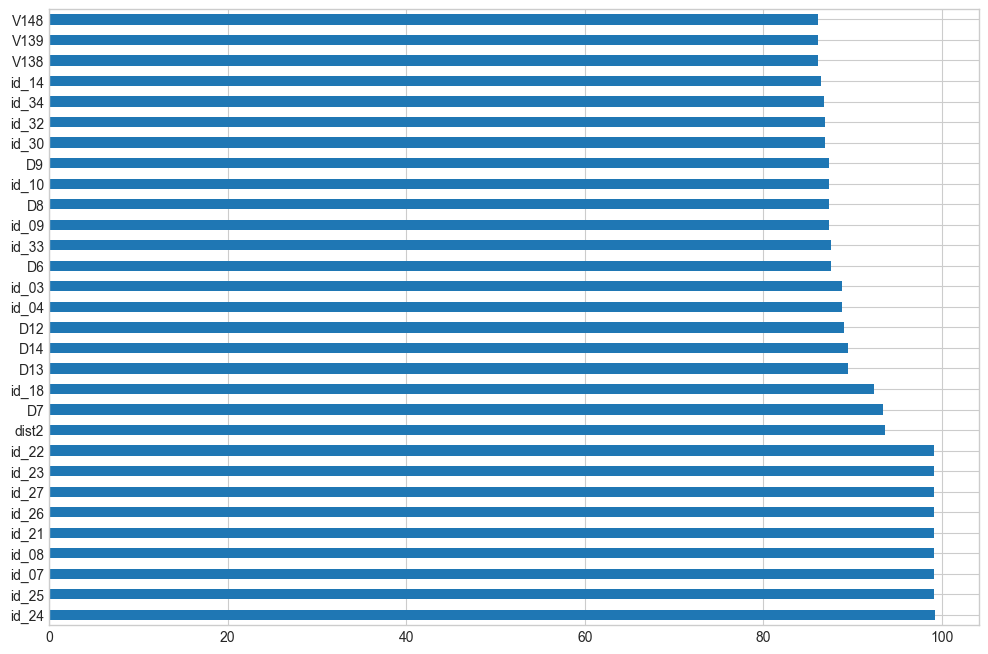

In [ ]:
# visualize missing pattern
top_missing = missing_pct.head(30)

fig, ax = plt.subplots(figsize=(12,8))
top_missing.plot(kind='barh', ax=ax)
ax.set_title('top 30 columns by missing pct')
ax.set_xlabel('missing (%) ')
ax.axvline(x=50, color='black', linestyle='--', label='50% thershold')
ax.legend()
plt.tight_layout()
plt.show()